<center><b><h1>Time to Rock!</h1></B></center>

<h2><b>Contents</b></h2>


* Project description
* Task 1: Feasibiliy analysis
* Task 2: Data extraction strategy
* Task 3: Solution implementation
* Task 4: Project Management

<h3><b>Project Description</b></h3>

An internal department in the Rockborne is looking to create a full and comprehensive 
list of travel time form some southeast English postcodes to the Wimbledon offices. 
They are expecting the output to be in a structured format.
The output expected (not limited) is the following:


<center>
<img src="expectedoutput.png" alt="Kitten" title="A cute kitten" width="650" height="195" /> 
</center>

They have provided the following data source for the postcodes: <br>
https://www.doogal.co.uk/UKPostcodes.php . <br><br>Even though is not an official data 
source, it is reliable, properly updated, cost free and has relevant additional data 
such as geographical data. <br><br>
The client knows that there are several providers from where to obtain the data, but 
they prefer Google Maps. An additional constraint is that they would like to be cost 
effective. Given that every API request has a cost involved and following the 
constraints of the project we need to make the requests effective. There are cases 
where the postcodes are close to each other or even are in the same building, 
considering this, one strategy is to select the most representative points in the 
data and just execute the API request on this representative sample; then the data 
can be replicated to the rest of data points.


<h3><b>Task 1: Feasibility Analysis</b></h3>

<b>Analyse the postcodes data source and if the information requested can be 
extracted from third party solutions. Perform and EDA on the data highlighting your 
findings and relevant attributes that can be considered to develop the solution. 
Probe that the extraction and data manipulation workflow work with a small sample. 
Elaborate your conclusions.<b>

For the initial postcode area, I will look at data available from Croydon from https://www.doogal.co.uk/BuiltUpAreaSD?area=E35001466.

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import requests
import json
from secret import apikey

worklat=51.4229
worklong=-0.2092

payload = {}
headers = {}

In [2]:
df=pd.read_csv('Croydon.csv')
df.head()

,Postcode,In Use?,Latitude,Longitude,Easting,Northing,Grid Ref,Introduced,Terminated,Altitude,Population,Households,Nearest Station,Distance To Station (KM),Built Up Area,Built Up Area Sub-Division,Water Company,Sewage Company
0,BR3 3BZ,Yes,51.378711,-0.027304,537388,166253,TQ373662,1/1/1980 12:00:00 AM,NaN,68,3.0,1.0,West Wickham,0.9,Greater London,Croydon,Thames Water,NaN
1,CR0 0WZ,No,51.375716,-0.091863,532904,165801,TQ329658,1/1/2005 12:00:00 AM,2/1/2006 12:00:00 AM,63,NaN,NaN,East Croydon,0.0,Greater London,Croydon,NaN,NaN
2,CR0 0XB,No,51.375212,-0.099600,532367,165731,TQ323657,5/1/1994 12:00:00 AM,8/1/2016 12:00:00 AM,65,NaN,NaN,Wellesley Road,0.1,Greater London,Croydon,NaN,NaN
3,CR0 0XD,Yes,51.375081,-0.098140,532469,165719,TQ324657,1/1/1991 12:00:00 AM,NaN,64,NaN,NaN,Wellesley Road,0.1,Greater London,Croydon,Thames Water,NaN
4,CR0 0XF,No,51.378521,-0.098989,532400,166100,TQ324661,1/1/1991 12:00:00 AM,12/1/1995 12:00:00 AM,63,NaN,NaN,West Croydon,0.2,Greater London,Croydon,NaN,NaN


In [6]:
df.dtypes

Postcode                       object
In Use?                        object
Latitude                      float64
Longitude                     float64
Easting                         int64
Northing                        int64
Grid Ref                       object
Introduced                     object
Terminated                     object
Altitude                        int64
Population                    float64
Households                    float64
Nearest Station                object
Distance To Station (KM)      float64
Built Up Area                  object
Built Up Area Sub-Division     object
Water Company                  object
Sewage Company                 object
dtype: object

There are a number of postcode which are no longer active, and hence they can be excluded for the purposes of this analysis

In [4]:
activepostcodes=df[df['In Use?']=='Yes'].shape[0]

print(f'There are originally {df.shape[0]} postcodes')
print(f'Once the inactive postcodes are removed, there are now {activepostcodes} postcodes')

df=df[df['In Use?']=='Yes']

There are originally 13184 postcodes
Once the inactive postcodes are removed, there are now 6895 postcodes


In [5]:
df.info

<bound method DataFrame.info of        Postcode In Use?   Latitude  Longitude  Easting  Northing  Grid Ref  \
0       BR3 3BZ     Yes  51.378711  -0.027304   537388    166253  TQ373662   
3       CR0 0XD     Yes  51.375081  -0.098140   532469    165719  TQ324657   
6       CR0 0XJ     Yes  51.370041  -0.099573   532384    165156  TQ323651   
8       CR0 0XT     Yes  51.374947  -0.091036   532964    165717  TQ329657   
9       CR0 0XZ     Yes  51.356521  -0.117739   531158    163620  TQ311636   
...         ...     ...        ...        ...      ...       ...       ...   
13179  SW16 5TR     Yes  51.412446  -0.127191   530341    169822  TQ303698   
13180  SW16 5TS     Yes  51.412012  -0.125929   530430    169776  TQ304697   
13181  SW16 5TT     Yes  51.410608  -0.124738   530517    169622  TQ305696   
13182  SW16 5TU     Yes  51.410552  -0.125212   530484    169615  TQ304696   
13183  SW16 5TX     Yes  51.411800  -0.126211   530411    169752  TQ304697   

                 Introduced Ter

In [6]:
df.dtypes

Postcode                       object
In Use?                        object
Latitude                      float64
Longitude                     float64
Easting                         int64
Northing                        int64
Grid Ref                       object
Introduced                     object
Terminated                     object
Altitude                        int64
Population                    float64
Households                    float64
Nearest Station                object
Distance To Station (KM)      float64
Built Up Area                  object
Built Up Area Sub-Division     object
Water Company                  object
Sewage Company                 object
dtype: object

The only columns which may be relevant to our analysis are:
* Postcode
* Latitude
* Longitude
* Grid ref

In [7]:
df=df[['Postcode','Latitude','Longitude']]

The minimum and maximum values of Latitude and Longitude are within the area of London, so there are no anomalous results

In [10]:
df.shape[0]

13184

In [9]:
df.describe()

,Latitude,Longitude
count,6895.000000,6895.000000
mean,51.368487,-0.094710
std,0.031350,0.026723
min,51.295191,-0.175719
25%,51.344031,-0.113266
50%,51.374981,-0.097483
75%,51.392806,-0.078767
max,51.423038,-0.024562


In [10]:
df.isnull().sum()

Postcode     0
Latitude     0
Longitude    0
Grid Ref     0
dtype: int64

Where multiple postcodes share the same grid reference, the same distance from Rockborne could potentially be applied.

In [11]:
originalrequests=df.shape[0]
groupedbygridref=df.groupby(['Grid Ref']).mean().shape[0]
print('If postcodes sharing the same grid references are grouped together, the number of unique requests will decrease from {} to {}'.format(originalrequests,groupedbygridref))

If postcodes sharing the same grid references are grouped together, the number of unique requests will decrease from 6895 to 4027


4000 requests would represent a cost of around $48, which would mean that for the whole SE area code the costs would be quite high. To reduce this the map could be divided manually into a grid with a size of our choosing and then grouped according to these grid locations. The distance for all postcodes within each area of the grid could be calculated from the centre point of each grid square.

In [12]:
minlat=df['Latitude'].min()
maxlat=df['Latitude'].max()
minlong=df['Longitude'].min()
maxlong=df['Longitude'].max()

print(f"horizontal range = {df['Latitude'].max()-df['Latitude'].min()}")
print(f"vertical range = {df['Longitude'].max()-df['Longitude'].min()}")

horizontal range = 0.1278469999999956
vertical range = 0.15115699999999999


Since the area is taller than it is wide, by setting a square grid there will definitely be squares which are unutilised. I estimate that around half of grid squares are used and I will aim to reduce this search to 500 requests, which means I will originally be designing the grid to have 1000 squares

In [13]:
numsquares=1000
area=(maxlat-minlat)*(maxlong-minlong)
gridlength=(area/numsquares)**0.5

z=((df['Latitude']-minlat)//gridlength).astype(int).astype(str)
g=((df['Longitude']-minlong)//gridlength).astype(int).astype(str)

df['Grid ID']=z+','+g

C:\Users\EamonSaeid\AppData\Local\Temp\ipykernel_1576\33879589.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Grid ID']=z+','+g


In [14]:
groupedbynewgrid=df.groupby(['Grid ID']).mean().shape[0]

print(f'Original number of requests: {originalrequests}')
print(f'Number of requests when grouped by original grid reference: {groupedbygridref}')
print(f'Number of requests when grouped by new grid of {numsquares} squares: {groupedbynewgrid}')

Original number of requests: 6895
Number of requests when grouped by original grid reference: 4027
Number of requests when grouped by new grid of 1000 squares: 542


In [15]:
data=[]
for gridlength in np.arange(0.001,0.01,0.001):
    z=((df.loc[:,'Latitude']-minlat)//gridlength).astype(int).astype(str)
    g=((df.loc[:,'Longitude']-minlong)//gridlength).astype(int).astype(str)

    df['Grid ID']=z+','+g
    groupedbynewgrid=df.groupby(['Grid ID']).mean().shape[0]
    cost=((groupedbynewgrid*3)/1000)*4
    dict={
        "Number of Requests":groupedbynewgrid,
        "Cost (£)":round(cost,2),
        "Grid Length (m)":int(gridlength/0.00001)
    }
    data.append(dict)
df2=pd.DataFrame(data)
df2
    

C:\Users\EamonSaeid\AppData\Local\Temp\ipykernel_1576\4058738718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Grid ID']=z+','+g
C:\Users\EamonSaeid\AppData\Local\Temp\ipykernel_1576\4058738718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Grid ID']=z+','+g
C:\Users\EamonSaeid\AppData\Local\Temp\ipykernel_1576\4058738718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

,Number of Requests,Cost (£),Grid Length (m)
0,4514,54.17,100
1,1994,23.93,200
2,1041,12.49,300
3,636,7.63,400
4,438,5.26,499
5,321,3.85,600
6,240,2.88,700
7,195,2.34,800
8,159,1.91,900


This method works, but will have an increased inaccuracy dependent on the grid length. It may be better the use a clustering algorithm to group nearby points, then the centroid of the cluster can be used as the point to measure the distance from for all the points in that cluster.

In [16]:
df=pd.read_csv('Croydon.csv')
df=df[df['In Use?']=='Yes']
df=df[['Postcode','Latitude','Longitude','Grid Ref']]

In [17]:
minlat=df['Latitude'].min()
maxlat=df['Latitude'].max()
minlong=df['Longitude'].min()
maxlong=df['Longitude'].max()

In [18]:
scaler=MinMaxScaler()
scaler.fit(df[['Latitude']])
df['Latitude']=scaler.transform(df[['Latitude']])
scaler.fit(df[['Longitude']])
df['Longitude']=scaler.transform(df[['Longitude']])

In [19]:
sse=[]
ntrials=1000
for n in range(1,ntrials,20):   
    km=KMeans(n_clusters=n)
    km.fit(df[['Latitude','Longitude']])
    sse.append(km.inertia_)

In [20]:
sse1=[]
for n in range(1,10):   
    km=KMeans(n_clusters=n)
    km.fit(df[['Latitude','Longitude']])
    df['Cluster ID']=km.fit_predict(df[['Latitude','Longitude']])
    df['Cluster Latitude']=km.cluster_centers_[df['Cluster ID'],0]
    df['Cluster Longitude']=km.cluster_centers_[df['Cluster ID'],1]
    df['Absolute error (m)']=((((df['Latitude']-df['Cluster Latitude'])**2)+((df['Longitude']-df['Longitude'])**2))**0.5)*(1.11/0.00001)

    dict={
        'Mean Absolute Error (m)':df['Absolute error (m)'].mean(),
        'Max Absolute Error (m)':df['Absolute error (m)'].max(),
        'Number of clusters':n
    }
    sse1.append(dict)
kmeanstest=pd.DataFrame(sse1)

In [21]:
kmeanstest

,Mean Absolute Error (m),Max Absolute Error (m),Number of clusters
0,22760.869860,63637.249852,1
1,12069.175922,36709.192862,2
2,11805.835881,33505.241535,3
3,8754.418885,33070.200714,4
4,7908.325045,35760.186543,5
5,7885.804447,32550.457207,6
6,7209.307120,31052.130958,7
7,6300.998145,22179.345143,8
8,6043.450196,22203.914635,9


TypeError: unhashable type: 'dict'

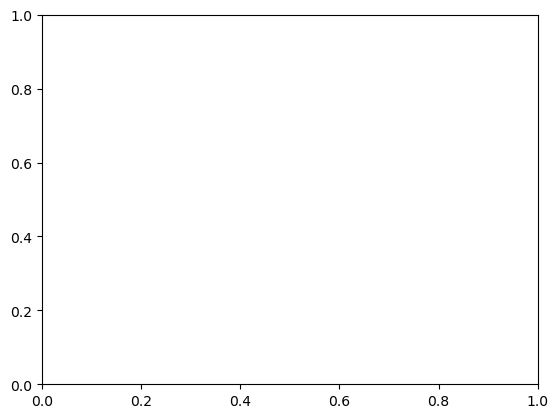

In [22]:
from importlib import reload
plt=reload(plt)
plt.plot(range(1,10),sse1)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')


Based on the graph above, the elbow point can be considered as 10. 

<h3><b>Task 2: Data Extraction Strategy</b></h3>

<b>Once you have validated that the extraction and manipulation of the data is possible: 
* Define a strategy to select and extract representative data points.
* Define the extraction strategy providing the justification of the algorithm 
implemented, the amount of the representative points suggested and how 
these will benefit the project. Provide the assumptions of the project and 
Add some visual support showing the postcodes and the representative 
points.</b>

<AxesSubplot:xlabel='Latitude', ylabel='Longitude'>

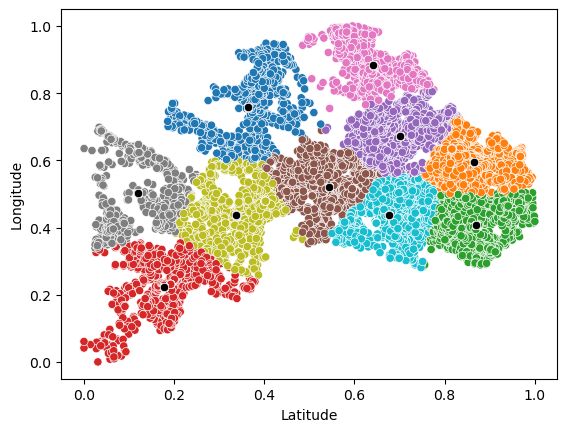

In [ ]:
km=KMeans(n_clusters=10)
km.fit(df[['Latitude','Longitude']])
y_predicted=km.fit_predict(df[['Latitude','Longitude']])
df['Cluster ID']=y_predicted
df['Cluster Latitude']=km.cluster_centers_[df['Cluster ID'],0]
df['Cluster Longitude']=km.cluster_centers_[df['Cluster ID'],1]
df

sns.scatterplot(x=df['Latitude'],y=df['Longitude'],hue=df['Cluster ID'], markers='x', palette=sns.color_palette(), legend=False)
sns.scatterplot(x=df['Cluster Latitude'], y=df['Cluster Longitude'], color='black')

In order to finalise the final DataFrame, the normalised Latitude and Longitude values must be returned to their original values, and extra columns can be removed.<br><br>Now that the clustering algorithm is complete, there are only 10 points from which the API must make a request, reducing the cost for this search to only 12 cents:<br> 10 locations * 3 searches/location * 0.005 $/search = $0.12


In [ ]:
df['Latitude']=minlat+df['Latitude']*(maxlat-minlat)
df['Cluster Latitude']=minlat+df['Cluster Latitude']*(maxlat-minlat)

df['Longitude']=minlong+df['Longitude']*(maxlong-minlong)
df['Cluster Longitude']=minlong+df['Cluster Longitude']*(maxlong-minlong)
df=df[['Postcode','Cluster ID', 'Latitude','Longitude','Cluster Latitude', 'Cluster Longitude']]
df.head(1)

,Postcode,Cluster ID,Latitude,Longitude,Cluster Latitude,Cluster Longitude
0,BR3 3BZ,6,51.378711,-0.027304,51.377098,-0.042277


Using the elbow point method determines the number of clusters by clustering up to the point that the variation from the centroid does not decrease significantly as more clusters are defined. This may be inaproppriate for this analysis because the specification is to use these centroids to calculate the commute times. Given the SSE when using 10 clusters, there will be large errors for points in each cluster furthest from the centroid.

[Text(0.5, 0, 'Number of Clusters'), Text(0, 0.5, 'Total API costs ($)')]

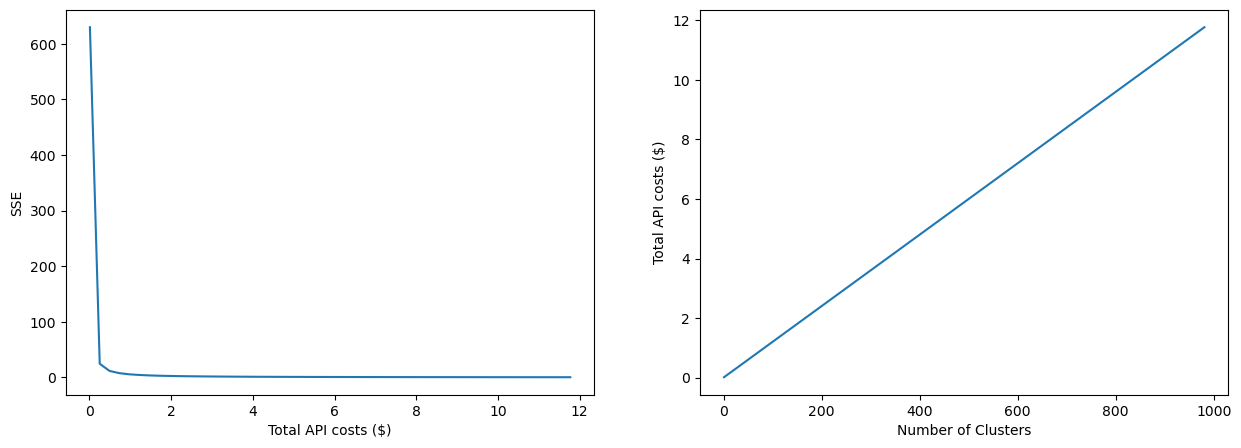

In [ ]:
reqcost=(4*3)/(1000)
fig, ax =plt.subplots(1,2, figsize=(15,5))
sns.lineplot(x=[i*reqcost for i in range(1,ntrials,20)],y=sse, ax=ax[0])
ax[0].set(xlabel='Total API costs ($)',ylabel='SSE')
sns.lineplot(x=[i for i in range(1,ntrials,20)],y=[i*reqcost for i in range(1,ntrials,20)], ax=ax[1])
ax[1].set(xlabel='Number of Clusters',ylabel='Total API costs ($)')

Fundamentally, there is a tradeoff to be made between accuracy of the end results and the cost of making multiple requests to google's api. The cost associated with the search given only 10 clusters is very low, and therefore there is leaway to increase the number of clusters and reduce the error.

[Text(0.5, 0, 'Number of Clusters'), Text(0, 0.5, 'SSE'), None]

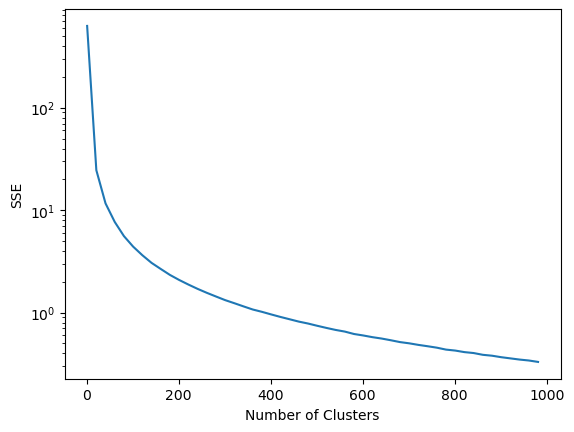

In [ ]:
ax=sns.lineplot(x=[i for i in range(1,ntrials,20)],y=sse)
ax.set(xlabel='Number of Clusters', ylabel='SSE', yscale='log')

As the graphs above show, maximising the number of clusters does reduce the SSE further, while the total API cost remains relatively low. Therefore to give an optimal result, it would be reasonable to select the maximum number of clusters that the client is willing to pay for. I will assume the client is willing to spend $5 on this search and therefore I will initially use 400 clusters.

<h3><b>Task 3: Solution Implementation</b></h3>

<b>

* Create a workflow that controls the API requests to Google Maps of the 
representative points postcodes you have stablished.
* Replicate the data of the representative points to the remaining postcodes
(all postcodes of the postcode area selected must have distance and time 
information by each transport option). Manipulate the data to fulfil the 
requirements. Provide the output file.
* Elaborate your conclusions and lessons learned.

</b>

Now the same analysis can be applied to the CSV document for the whole of south east London

In [ ]:
df=pd.read_csv('SE postcodes.csv')
df['Latitude'].describe()
#This dataset included one value of Latitude which was anomalous and hence needed to be removed
df=df[df['Latitude']>=45] 
df=df[df['In Use?']=='Yes']
df=df[['Postcode','Latitude','Longitude','Grid Ref']]
df.head(1)

,Postcode,Latitude,Longitude,Grid Ref
0,SE1 0AA,51.498708,-0.101772,TQ318794


In [ ]:
minlat=df['Latitude'].min()
maxlat=df['Latitude'].max()
minlong=df['Longitude'].min()
maxlong=df['Longitude'].max()

In [ ]:
scaler=MinMaxScaler()
scaler.fit(df[['Latitude']])
df['Latitude']=scaler.transform(df[['Latitude']])
scaler.fit(df[['Longitude']])
df['Longitude']=scaler.transform(df[['Longitude']])
df.head(3)

,Postcode,Latitude,Longitude,Grid Ref
0,SE1 0AA,0.890958,0.084154,TQ318794
1,SE1 0AB,0.932934,0.108020,TQ322800
2,SE1 0AD,0.897731,0.087050,TQ319795


In [ ]:
sse=[]
for n in range(1,1000,20):  
    km=KMeans(n_clusters=n, max_iter=300)
    km.fit(df[['Latitude','Longitude']])
    sse.append(km.inertia_)

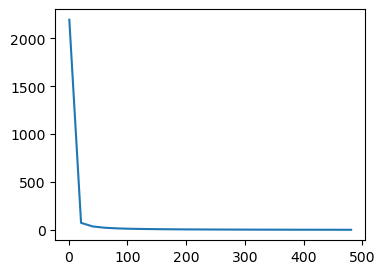

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(range(1,500,20),sse[:25])

In [ ]:
km=KMeans(n_clusters=400, max_iter=1500)
km.fit(df[['Latitude','Longitude']])
y_predicted=km.fit_predict(df[['Latitude','Longitude']])
df['Cluster ID']=y_predicted
df['Cluster Latitude']=km.cluster_centers_[df['Cluster ID'],0]
df['Cluster Longitude']=km.cluster_centers_[df['Cluster ID'],1]
df.head(1)

,Postcode,Latitude,Longitude,Grid Ref,Cluster ID,Cluster Latitude,Cluster Longitude
0,SE1 0AA,0.890958,0.084154,TQ318794,83,0.89746,0.06816


C:\Users\EamonSaeid\AppData\Local\Temp\ipykernel_23136\168490857.py:1: UserWarning: 
The palette list has fewer values (10) than needed (400) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=df['Latitude'],y=df['Longitude'],hue=df['Cluster ID'], markers='x', palette=sns.color_palette('colorblind'), legend=False)


<AxesSubplot:xlabel='Latitude', ylabel='Longitude'>

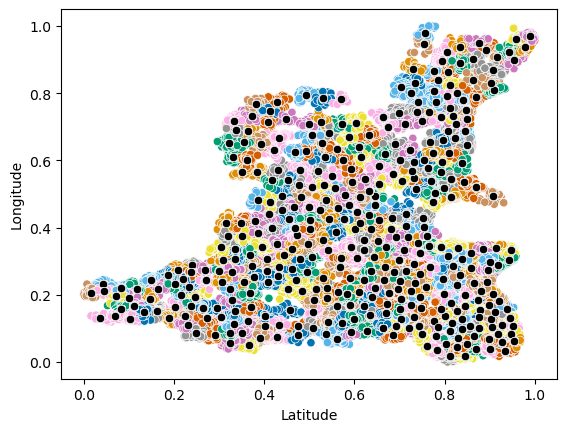

In [ ]:
sns.scatterplot(x=df['Latitude'],y=df['Longitude'],hue=df['Cluster ID'], markers='x', palette=sns.color_palette('colorblind'), legend=False)
sns.scatterplot(x=df['Cluster Latitude'], y=df['Cluster Longitude'], color='black')

In [ ]:
df2=df[['Postcode','Cluster ID','Cluster Latitude','Cluster Longitude' ]].groupby(['Cluster ID']).mean()[['Cluster Latitude', 'Cluster Longitude']]
df2['Cluster Latitude']=minlat+df2['Cluster Latitude']*(maxlat-minlat)
df2['Cluster Longitude']=minlong+df2['Cluster Longitude']*(maxlong-minlong)
df2.head(3)

NameError: name 'df' is not defined

In [ ]:
def commutetime(latitude,longitude):
    transportmodes=['driving','transit','walking']
    time=[]
    for transportmode in transportmodes:
        try:
            url = "https://maps.googleapis.com/maps/api/distancematrix/json?origins={}%2C{}&destinations={}%2C{}&mode={}&key={}".format(worklat,worklong,str(latitude),str(longitude),transportmode,apikey)
            response = requests.request("GET", url, headers=headers, data=payload)
            duration=int(response.json()['rows'][0]['elements'][0]['duration']['value']/60) # Converts seconds to minutes
            distance=int(response.json()['rows'][0]['elements'][0]['distance']['value']/1000) # Converts meters to km
        except:
            duration='N/A'
            distance='N/A'
        time.append([transportmode,duration,distance])
    return time

In [ ]:
drivinglen, drivingdist,transitlen, transitdist, walkinglen, walkingdist=[],[],[],[],[],[]

for i in range(0,len(df2)):
    data=commutetime(df2.iloc[i,0],df2.iloc[i,1])
    drivinglen.append(data[0][1])
    drivingdist.append(data[0][2])
    transitlen.append(data[1][1])
    transitdist.append(data[1][2])
    walkinglen.append(data[2][1])
    walkingdist.append(data[2][2])

In [ ]:
df2['Driving duration (mins)'], df2['Driving distance (km)'],df2['Transit duration (mins)']=drivinglen, drivingdist,transitlen
df2['Transit distance (km)'],df2['Walking duration (mins)'],df2['Walking distance (km)']= transitdist, walkinglen, walkingdist
df2.drop(['Cluster Latitude','Cluster Longitude'],axis=1, inplace=True)
df2.head(3)

,Driving duration (mins),Driving distance (km),Transit duration (mins),Transit distance (km),Walking duration (mins),Walking distance (km)
Cluster ID,,,,,,
0,50,15,70,17,188,15
1,50,18,92,29,219,17
2,38,13,81,19,155,12


In [ ]:
df3=pd.merge(
    df,
    df2,
    how="inner",
    on='Cluster ID',
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)
df3=df3[['Postcode','Driving duration (mins)','Driving distance (km)','Transit duration (mins)','Transit distance (km)','Walking duration (mins)','Walking distance (km)']]

In [ ]:
df3.to_csv('Final results2.csv')

In [12]:
xyz=pd.read_csv('Final results2.csv')

In [13]:
xyz

,Unnamed: 0,Postcode,Driving duration (mins),Driving distance (km),Transit duration (mins),Transit distance (km),Walking duration (mins),Walking distance (km)
0,0,SE1 0AA,41,14,54,14,156,12
1,1,SE1 0AE,41,14,54,14,156,12
2,2,SE1 0AG,41,14,54,14,156,12
3,3,SE1 0AH,41,14,54,14,156,12
4,4,SE1 0AN,41,14,54,14,156,12
...,...,...,...,...,...,...,...,...
20552,20552,SE9 6LE,56,21,97,32,254,20
20553,20553,SE9 6QN,56,21,97,32,254,20
20554,20554,SE9 6QP,56,21,97,32,254,20
20555,20555,SE9 6QQ,56,21,97,32,254,20


<h3><b>Task 4: Project Management</b></h3>

<b>
Develop a plan that states the different activities that covers the software 
development lifecycle (project definition, development, testing and deploy) under 
the paradigm of your choice. The following additional deliverables should be 
considered for the development: High level solution design, algorithm logic 
representation, presentation of the project that covers the tasks one to three. 
Additional deliverables that complement the project can be added to the scope. 
Weekly meetings have been planned with the user to update the progress, clarify 
questions and/or assumptions and refine requirements. 
</b>

<b><h5>Project definition</h5></b>
The requirements are defined to a concise list of key deliverables, with clearly defined timelines. This will involve meeting with the client to understand their needs for the project in terms of how the output data will be used, their timeline and their budget. Based on this we can offer advice and suggestions on how to complete the project in a way which suits their needs, and hopefully innovate on their initial plans to offer them better value.

<b><h5>Development</h5></b>
The project is built to the specifications outlined during the project definition stage, using a sample region to reduce API costs. This allows us to return to the client with an example product/output, which will allow them the opportunity to share their opinions and guidance as to whether they're happy with the work provided. Once the project has been confirmed to meet client requirements, a high level solution design including an algorithm logic representation can be produced into a PDF document or powerpoint presentation to show to stakeholders.

<b><h5>Testing</h5></b>
Once the intial solution has been validated by the client, the project can then be tested using a range of input data to verify that the code will work dynamically. This will involve checking the data source and the inconsistencies in the data provided, and building a system that will successfully clean and cluster the data while accounting for changes such as column labelling errors or anomalous results. For example, I found that for the input data for all postcodes there was an anomalous result which required a further data cleaning step. The testing stage would identify and mitigate for all these potential inaccuracies.

<b><h5>Deployment</h5></b>
The project should be finalised into a .py file which asks for input from the user and guides the user through the data cleaning and clustering process. This would allow the end user to check that there are sufficient clusters and that data cleaning worked as expected, to reduce the chance of API requests being wasted.